In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.integrate import quad
from scipy import special
from mpmath import hyp1f1
import mpmath as mp
from scipy.integrate import dblquad
from multiprocessing import Pool
from functools import partial
import astropy.constants as cte #cte
import astropy.units as unt  #unt
import sympy as sp
import math

In [42]:
pc = cte.pc.to_value()
kpc = cte.kpc.to_value()
c = cte.c.to_value()
MSun = cte.M_sun.to_value()
G_num = cte.G.to_value()

In [43]:
rho_0 = 7.9e-3*MSun/(pc)**3
pi    = np.pi
a     = 5*kpc 
R_0   = 8.5*kpc 
D_S   = np.array([1,5,10,55])*kpc

In [44]:
def integrand_OD_KG(x,angle,D_s):
    A     = (a**2+R_0**2)/D_s**2
    B     = R_0/D_s
    tau_0 = (4*pi*G_num*rho_0*(a**2+R_0**2))/(c**2) #4.61*10**-7
    return tau_0*x*(1-x)/(x**2+A-2*x*B*angle)

In [45]:
angles = np.linspace(-1,1,120)
I_s    = np.zeros([len(angles),4])

In [46]:
angle_lmc = np.cos(math.radians(-32.8))*np.cos(math.radians(281))
tau_lmc_0 = integrate.fixed_quad(lambda x: integrand_OD_KG(x,angle_lmc, D_S[3]), 0, 1,n=10)
tau_lmc   = tau_lmc_0[0]
print(round(tau_lmc,8)) #Da perfecto!

5.1e-07


In [47]:
#@title Integro y ploteo
L=np.array([1,5,10,55])
for j in range(len(D_S)):
    for i in range(len(angles)):
        I_j = integrate.fixed_quad(lambda x: integrand_OD_KG(x,angles[i],D_S[j]), 0, 1,n=9)
        I_s[i,j]=I_j[0]

5.104534452369212e-07


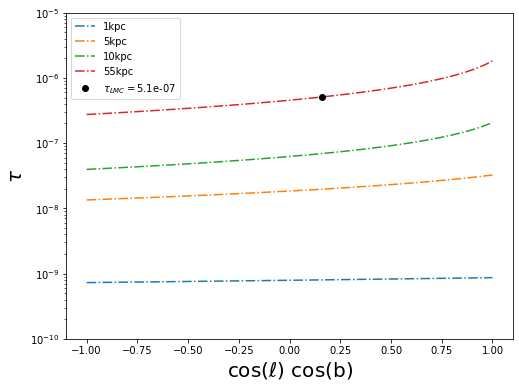

In [48]:
plt.figure(1,figsize=(8,6))
plt.ylim(10e-11,10e-6)
plt.semilogy(angles,I_s[:,0],'-.',label=str(L[0])+'kpc')
plt.semilogy(angles,I_s[:,1],'-.',label=str(L[1])+'kpc')
plt.semilogy(angles,I_s[:,2],'-.',label=str(L[2])+'kpc')
plt.semilogy(angles,I_s[:,3],'-.',label=str(L[3])+'kpc')
plt.plot(angle_lmc,tau_lmc,'o',color='black',label=r'$\tau_{LMC}=$'+str(round(tau_lmc,8)))
plt.ylabel(r'$\tau$', fontsize=20)
plt.xlabel(r'cos($\ell$) cos(b)', fontsize=20)
plt.legend(loc=2)
print(tau_lmc)

5.104534452369212e-07


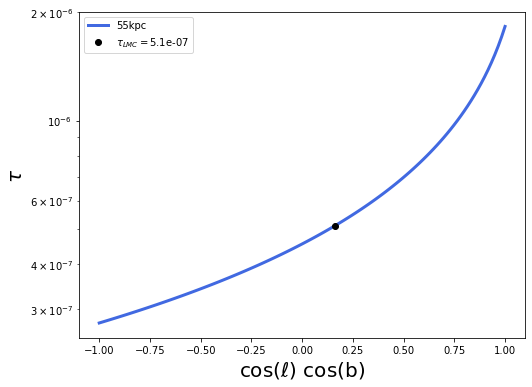

In [49]:
plt.figure(1,figsize=(8,6))
plt.semilogy(angles,I_s[:,3],color='royalblue',linestyle='-',lw=3,label=str(L[3])+'kpc')
plt.plot(angle_lmc,tau_lmc,'o',color='black',label=r'$\tau_{LMC}=$'+str(round(tau_lmc,8)))
plt.ylabel(r'$\tau$', fontsize=20)
plt.xlabel(r'cos($\ell$) cos(b)', fontsize=20)
plt.legend(loc=2)
print(tau_lmc)

In [50]:

d = sp.Symbol('d')
d_s = sp.Symbol('d_s')

rho_c_MW = 4.88 * 10**6 * (MSun/kpc**3)
rho_c_M31 = 4.96 * 10**6 * (MSun/kpc**3)
r_s_MW = 21.5 * kpc
r_s_M31 = 25 * kpc
d_s = 770 * kpc


In [51]:
def r_MW(d,l,b):
    '''
    Separação do PBH ao centro de MW, em termos de d. Equação 9.
    
    d: distância observado-lente.
    '''
    
    r_mw = np.sqrt(R_0**2 + d**2 - 2*R_0*d*np.cos(math.radians(l))*np.cos(math.radians(b))) 
    
    return r_mw

def r_M31(d,l,b):
    
    '''
    Distância para o PBH do centro de M31. Equação 10.
    
    d_s: distância observador-fonte.
    '''
    
    r_m31 = d_s - d
    
    return r_m31
    
def density_DM(d,l,b):
    
    '''
    Densidade de DM.
    '''

    
    term1 =  rho_c_MW
    term2 = (r_MW(d,l,b) / r_s_MW)
    term3 = (1 + r_MW(d,l,b) / r_s_MW)**2
    
    term4 = rho_c_M31               
    term5 = (r_M31(d,l,b) / r_s_M31)
    term6 = (1 + r_M31(d,l,b) / r_s_M31)**2
    
    return (term1 /(term2 * term3)) + (term4 / (term5 * term6)) 



def integrando(d,l,b):
    
    '''
    Quantidade dentro da integral da profundidade óptica.
    '''
    
    integrando = (density_DM(d,l,b)) * ((4*np.pi*G_num)/c**2) * d * (1 - (d/d_s))
    
    return integrando



@np.vectorize
def optical_depht(d,l,b):
    
    '''
    Profundidade óptica. Equação 11.
    '''
    
    integral = quad(integrando, 0, d, epsrel=1e-10,args = (l,b,),)[0] #args=(rho_c, r_s, R_0, d_s, l, b,),    
    
    return integral



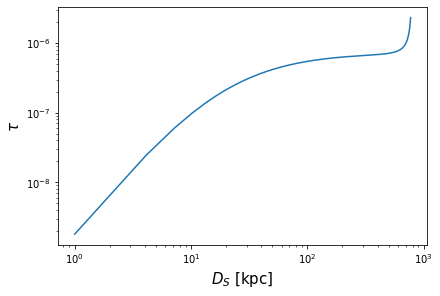

In [52]:
fig, ax = plt.subplots(constrained_layout=True)

d0 = np.linspace(1,770, 250)*kpc
l = 121.2 # degree
b = -21.6 # degree
d1 = np.linspace(1,770, 250)

ax.loglog(d1, optical_depht(d0,l,b))

ax.set_xlabel(r'$D_S$ [kpc]', fontsize=15)
plt.ylabel(r'$\tau$', fontsize=15) 
plt.xticks(d1)
# ax.set_title('Profundidade óptica HSC', fontsize=15)

def d_kpc(d0):
    return  d0/kpc 

def d_m(d0):
    return d0

# secax = ax.secondary_xaxis('top', functions=(d_kpc, d_m))
# secax.set_xlabel('kpc', fontsize=15)
plt.xscale('log')
plt.yscale('log')
# plt.grid(True)
plt.show()




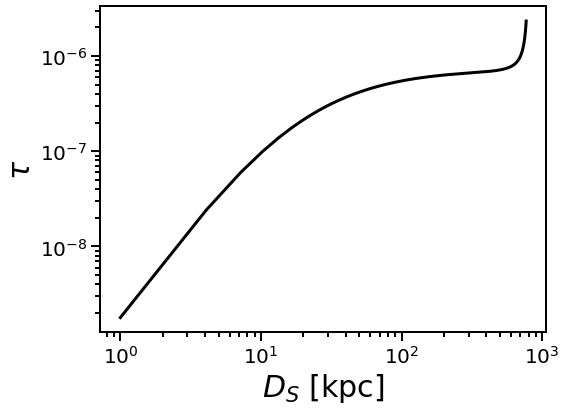

In [53]:
# fig, ax = plt.subplots(constrained_layout=True)

d0 = np.linspace(1,770, 250)*kpc
l = 121.2 # degree
b = -21.6 # degree
d1 = np.linspace(1,770, 250)

# ax.loglog(d1, optical_depht(d0,l,b))

# plt.xticks(d1)

def d_kpc(d0):
    return  d0/kpc 

def d_m(d0):
    return d0



#---------------------------------------------------------------------------------
plt.figure(figsize=(8,6))
ax=plt.axes()

# plt.xlim(-1,1)
plt.yticks([1e-5,1e-6,2.7e-7],['1e-5','1e-6','1e-7'])
plt.xticks(d1)
plt.plot(d1, optical_depht(d0,l,b),linestyle='-', lw=3,color='black' ,label='NFW')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\tau$',fontsize=30)
plt.xlabel(r'$D_S$ [kpc]',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5, color='black')
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5, color='black')

<ipython-input-51-cdb8b3d58b51>:39: RuntimeWarning: divide by zero encountered in double_scalars
  return (term1 /(term2 * term3)) + (term4 / (term5 * term6))


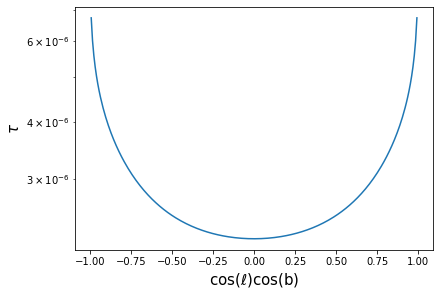

In [54]:
fig, ax = plt.subplots(constrained_layout=True)

d0 = 770*kpc
l = 0 # degree
b = np.linspace(0,360,250) # degree
# plt.xlim(-1,0)
# print(optical_depht(d0,0,b))
angle = np.linspace(-1,1,250)
ax.plot(angle, optical_depht(d0,l,b))

ax.set_xlabel(r'cos($\ell$)cos(b)', fontsize=15)
plt.ylabel(r'$\tau$', fontsize=15) 

# plt.xscale('log')
plt.yscale('log')
# plt.grid(True)

In [55]:
def r(d,l,b):
    '''
    r es la distancia al punto descrito por el perfil rho, puede ser una esfera isoterma, NFW, o alguno de materia barionica.
    l,b son los angulos de coordenadas galacticas.    
    d: distancia al punto donde se observe.
    '''

#     r_cg = np.sqrt(R_0**2 + d**2 - 2*R_0*d*np.cos(math.radians(l))*np.cos(math.radians(b)))
    r_cg = np.sqrt(R_0**2 + d**2 - 2*R_0*d*np.cos(math.radians(l))*np.cos(math.radians(b)))
    return r_cg

def density_NFW(d,l,b):
    
    '''
    Densidad NFW para MW.
    '''
    #angulos LMC
#     l     = -32.8
#     b     = 281
    term1 =  rho_c_MW
    term2 = (r(d,l,b) / r_s_MW)
    term3 = (1 + r(d,l,b) / r_s_MW)**2
    
#     term4 = rho_c_M31               
#     term5 = (r_M31(d) / r_s_M31)
#     term6 = (1 + r_M31(d) / r_s_M31)**2
    
    return (term1 /(term2 * term3)) #+ (term4 / (term5 * term6)) 
    

def integrando_NFW(d,l,b):
    
    '''
    Integrando profundidad optica.
    '''
    
    integrando = (density_NFW(d,l,b)) * ((4*np.pi*G_num)/c**2) * d * (1 - (d/d_s))
    
    return integrando


@np.vectorize
def optical_depht_NFW(d,l,b):
    
    '''
    Profundidade óptica. Equação 11.
    '''
    
    integral = quad(integrando_NFW, 0, d, epsrel=1e-10,args=(l,b,) , )[0] #args=(rho_c, r_s, R_0, d_s, l, b,),    
    
    return integral

<ipython-input-55-b59d6a77c953>:28: RuntimeWarning: divide by zero encountered in double_scalars
  return (term1 /(term2 * term3)) #+ (term4 / (term5 * term6))


2.743778678432034e-07 1.8270377515741446e-06 5.104534452369212e-07


<ipython-input-55-b59d6a77c953>:28: RuntimeWarning: divide by zero encountered in double_scalars
  return (term1 /(term2 * term3)) #+ (term4 / (term5 * term6))


4.750531670176973e-06 4.750531670176973e-06 3.6645344523692116e-07


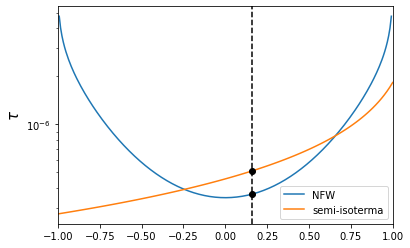

In [56]:
# fig, ax = plt.subplots(constrained_layout=True)

D = 55*kpc
l = np.linspace(0,360, 250)
b = 0
angle = np.linspace(-1,1, 250)

plt.xlim(-1,1)
plt.yticks([1e-5,1e-6,2.7e-7],['1e-5','1e-6','1e-7'])
plt.plot(angle, optical_depht_NFW(D,l,b),label='NFW')
plt.plot(angles,I_s[:,3],linestyle='-',lw=1.5,label='semi-isoterma')
plt.plot(angle_lmc,tau_lmc,'o',color='black')
plt.plot(angle_lmc,tau_lmc-0.144e-6,'o',color='black')
plt.axvline(x =angle_lmc, ymin=0, ymax=1,linestyle = '--', color='black')

print(I_s[:,3][0],I_s[:,3][-1],tau_lmc)
print(optical_depht_NFW(D,l,b)[1],optical_depht_NFW(D,l,b)[248],tau_lmc-0.144e-6)

ax.set_xlabel(r'cos($\ell$)cos(b)', fontsize=15)
plt.ylabel(r'$\tau$', fontsize=15) 
plt.yscale('log')
# plt.grid(True)
plt.legend(loc='best')
plt.show()




<ipython-input-55-b59d6a77c953>:28: RuntimeWarning: divide by zero encountered in double_scalars
  return (term1 /(term2 * term3)) #+ (term4 / (term5 * term6))


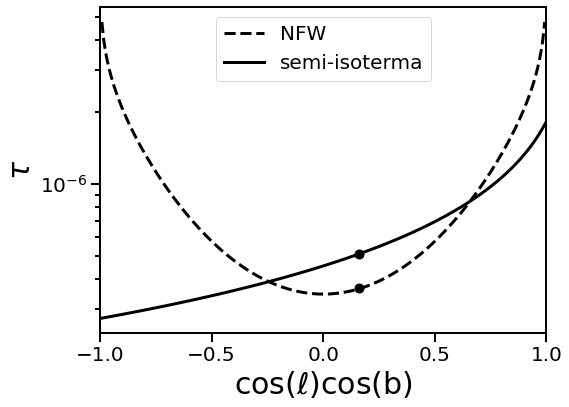

In [58]:
plt.figure(figsize=(8,6))
ax=plt.axes()


plt.xlim(-1,1)
plt.yticks([1e-5,1e-6,2.7e-7],['1e-5','1e-6','1e-7'])
plt.xticks([-1,-0.5,0,0.5,1])

plt.plot(angle, optical_depht_NFW(D,l,b),linestyle='--', lw=3,color='black' ,label='NFW')
plt.plot(angles,I_s[:,3],linestyle='-',lw=3,color= 'black' ,label='semi-isoterma')
plt.plot(angle_lmc,tau_lmc,marker='o',markersize=9,color='black')
plt.plot(angle_lmc,tau_lmc-0.144e-6,marker='o',markersize=9,color='black')
# plt.axvline(x =angle_lmc, ymin=0, ymax=1,linestyle = '-', color='black')
plt.yscale('log')


plt.ylabel(r'$\tau$',fontsize=30)
plt.xlabel(r'cos($\ell$)cos(b)',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5, color='black')
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5, color='black')
plt.legend(loc='best',fontsize=20)
